# New Measure - Inhalers and the environment

## Rationale


The NHS 10 year plan comits the NHS to reduce harmful enviromental emissions. One way of doing this is to shift from Metered Dose Inhalers (MDI) to Dry Powdered Inhalers (DPI). This notebook is a prototype for modelling the current prescribing patterns in England.

## Proposed Measure

### Title
Proprotion of MDI items prescribed as a total of all inhalers items excluding salbutamol

### Description
Proprotion of MDIs prescribed as a total of all inhalers from the respiratory chapter in the BNF excluding salbutamol

### Why it matters
The NHS has comitted to reducing enviromental emissions by x% by 20xx. An estimated x% of emissions come from inhalers. Dry pwoder inhalers (DPIs) are less harmful to the enviroment than traditional metered dose inhalers (MDIs) and the NHS long term plan supports the use of DPI where it is clinically appropriate. NICE have produced an [inhaler decision aid](https://www.nice.org.uk/guidance/ng80/resources/inhalers-for-asthma-patient-decision-aid-pdf-6727144573) to faciltiate decisons about inhalers. You can read more about this measure on our blog [here](https://docs.google.com/document/d/1OQeuHV0AKB8VG87DUcUSjaj7Dre3jKJ7oIjRokaS-uI/edit), including the rationale for excluding salbutamol

## Numerators & Denominators 
They can be viewed here on this [google sheet](https://docs.google.com/spreadsheets/d/1aZGJkN-HF0PrYqmWpIdr72J9sVZGpLm2b1-T-ooje3g/edit#gid=0) (Correct as of prescribing data May 2019 - update befre launch).  At OpenPrescribing we use live automated code and this should always be consulted as the current reference. Branded Inhalers or BNF codes released prior to x 2019 will not be included on this spreadsheet.

## SQL and Mock up

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [2]:
sql = '''
SELECT
    practice,
    pct,
    CAST(month AS DATE) AS month,
    SUM(items) AS numerator
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE 
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM measures.vw__chapter_3_dmd_objs_with_form_route
        WHERE form_route = 'pressurizedinhalation.inhalation'
        ) 
AND bnf_code NOT LIKE "0301011R0%"
GROUP BY practice, pct, month
ORDER BY practice, month
'''

df_inh_numerator = bq.cached_read(sql, csv_path='df_inh_numerator.csv')
df_inh_numerator['month'] = df_inh_numerator['month'].astype('datetime64[ns]')
df_inh_numerator.head()

,practice,pct,month,numerator
0,A81001,00K,2010-08-01,96
1,A81001,00K,2010-09-01,127
2,A81001,00K,2010-10-01,132
3,A81001,00K,2010-11-01,114
4,A81001,00K,2010-12-01,136


In [3]:
df_inh_numerator.head()

,practice,pct,month,numerator
0,A81001,00K,2010-08-01,96
1,A81001,00K,2010-09-01,127
2,A81001,00K,2010-10-01,132
3,A81001,00K,2010-11-01,114
4,A81001,00K,2010-12-01,136


In [4]:
sql = '''
SELECT
    practice,
    pct,
    CAST(month AS DATE) AS month,
    SUM(items) AS denominator
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM measures.vw__chapter_3_dmd_objs_with_form_route
        WHERE form_route IN ('pressurizedinhalation.inhalation', 'powderinhalation.inhalation')
        )
AND bnf_code NOT LIKE "0301011R0%"
GROUP BY practice, pct, month
ORDER BY practice, month
'''

df_inh_denominator = bq.cached_read(sql, csv_path='df_inh_denominator.csv')
df_inh_denominator['month'] = df_inh_denominator['month'].astype('datetime64[ns]')
df_inh_denominator.head()

,practice,pct,month,denominator
0,A81001,00K,2010-08-01,168
1,A81001,00K,2010-09-01,222
2,A81001,00K,2010-10-01,215
3,A81001,00K,2010-11-01,226
4,A81001,00K,2010-12-01,224


In [5]:
df_practice = pd.merge(df_inh_numerator, df_inh_denominator)
df_practice['measure_value'] = df_practice['numerator'] / df_practice['denominator']
df_practice.head()

,practice,pct,month,numerator,denominator,measure_value
0,A81001,00K,2010-08-01,96,168,0.571429
1,A81001,00K,2010-09-01,127,222,0.572072
2,A81001,00K,2010-10-01,132,215,0.613953
3,A81001,00K,2010-11-01,114,226,0.504425
4,A81001,00K,2010-12-01,136,224,0.607143


In [6]:
df_ccg = df_practice.groupby(['pct', 'month'])['numerator', 'denominator'].sum().reset_index()
df_ccg['measure_value'] = df_ccg['numerator'] / df_ccg['denominator']
df_ccg.head()

,pct,month,numerator,denominator,measure_value
0,00C,2010-08-01,2014,3848,0.523389
1,00C,2010-09-01,2186,4151,0.526620
2,00C,2010-10-01,2133,3983,0.535526
3,00C,2010-11-01,2218,4206,0.527342
4,00C,2010-12-01,2431,4666,0.521003


In [7]:
df_ccg.head()

,pct,month,numerator,denominator,measure_value
0,00C,2010-08-01,2014,3848,0.523389
1,00C,2010-09-01,2186,4151,0.526620
2,00C,2010-10-01,2133,3983,0.535526
3,00C,2010-11-01,2218,4206,0.527342
4,00C,2010-12-01,2431,4666,0.521003


### Decile Charts

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


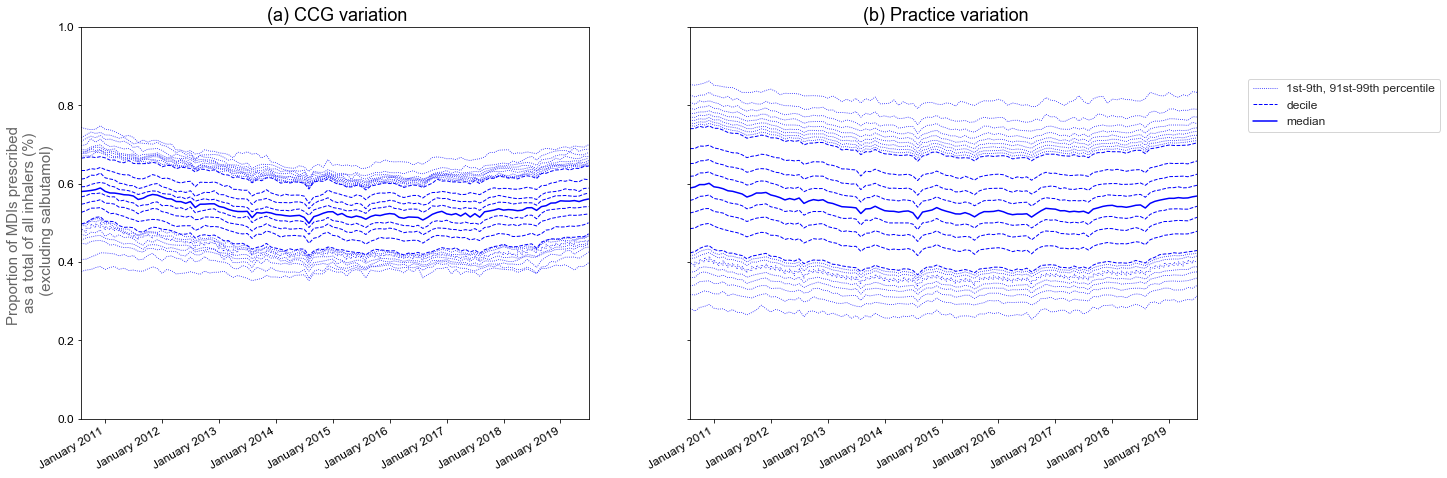

In [8]:
f = plt.figure(figsize=(20,8))
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    df_ccg,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation",
    ylabel="Proportion of MDIs prescribed \n as a total of all inhalers (%) \n  (excluding salbutamol) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 

charts.deciles_chart(
    df_practice,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 1)
plt.show()

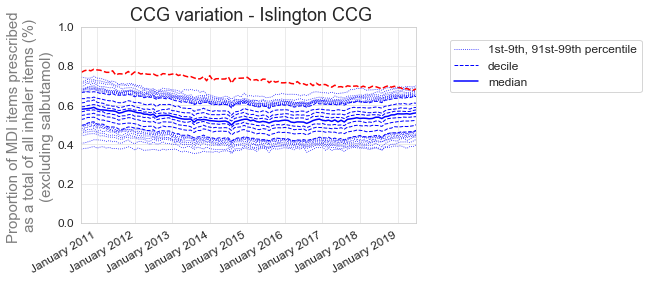

In [9]:
###here we chart a ccg example
charts.deciles_chart(
    df_ccg,
    period_column='month',
    column='measure_value',
    title=" CCG variation - Islington CCG",
    ylabel="Proportion of MDI items prescribed \n as a total of all inhaler items (%) \n (excluding salbutamol)  ",
    show_outer_percentiles=True,
    show_legend=True 
) 


#add in example CCG (Islington - 08h)
df_subject = df_ccg.loc[df_ccg['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')
plt.ylim(0, 1)
plt.show()

In [10]:
ccg_june = df_ccg.loc[df_ccg['month'] == "2019-06-01"].groupby('pct').sum().reset_index()
ccg_june.head()

,pct,numerator,denominator,measure_value
0,00C,2309,5065,0.455874
1,00D,8451,18904,0.447048
2,00J,5705,13014,0.438374
3,00K,8250,17744,0.464946
4,00L,6722,17290,0.388780


### Map

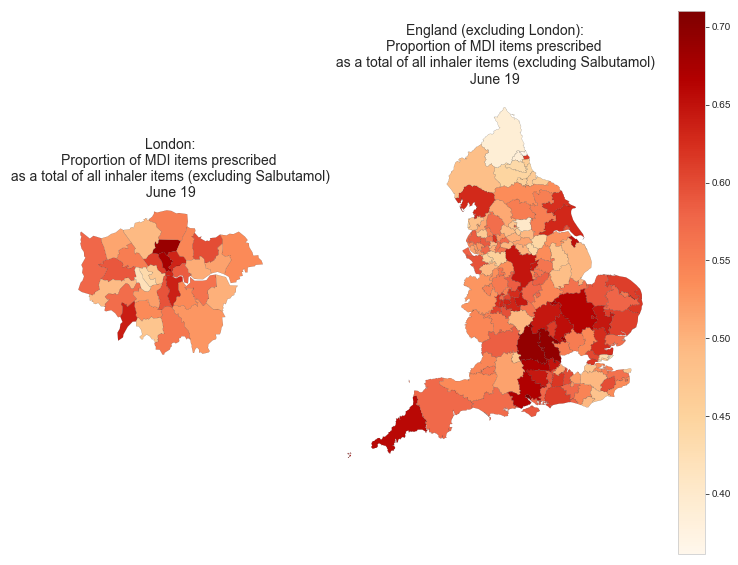

In [11]:
plt.figure(figsize=(12,10))
plt = maps.ccg_map(ccg_june, title="Proportion of MDI items prescribed \n as a total of all inhaler items (excluding Salbutamol) \n June 19 ", column='measure_value', cartogram=False, separate_london=True)
plt.show()

### Including Salbutamol
For completeness we will model the figures including salbutamol.

In [12]:
sql = '''
SELECT
    practice,
    pct,
    CAST(month AS DATE) AS month,
    SUM(items) AS numerator
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE 
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM measures.vw__chapter_3_dmd_objs_with_form_route
        WHERE form_route = 'pressurizedinhalation.inhalation'
        )
GROUP BY practice, pct, month
ORDER BY practice, month
'''
num_incl_salb = bq.cached_read(sql, csv_path='num_incl_salb.csv', use_cache=True)
num_incl_salb['month'] = num_incl_salb['month'].astype('datetime64[ns]')
num_incl_salb.head(5)





,practice,pct,month,numerator
0,A81001,00K,2010-08-01,210
1,A81001,00K,2010-09-01,247
2,A81001,00K,2010-10-01,255
3,A81001,00K,2010-11-01,233
4,A81001,00K,2010-12-01,285


In [13]:
sql = '''
SELECT
    practice,
    pct,
    CAST(month AS DATE) AS month,
    SUM(items) AS denominator
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE 
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM measures.vw__chapter_3_dmd_objs_with_form_route
        WHERE form_route IN ('pressurizedinhalation.inhalation', 'powderinhalation.inhalation')
    )
GROUP BY practice, pct, month
ORDER BY practice, month
'''

denom_incl_salb = bq.cached_read(sql, csv_path='denom_incl_salb.csv', use_cache=True)
denom_incl_salb['month'] = denom_incl_salb['month'].astype('datetime64[ns]')
denom_incl_salb.head(5)



,practice,pct,month,denominator
0,A81001,00K,2010-08-01,289
1,A81001,00K,2010-09-01,355
2,A81001,00K,2010-10-01,344
3,A81001,00K,2010-11-01,358
4,A81001,00K,2010-12-01,382


In [14]:
df_practice_salb = pd.merge(num_incl_salb, denom_incl_salb)
df_practice_salb['measure_value'] = df_practice_salb['numerator'] / df_practice_salb['denominator']
df_practice_salb.head()

,practice,pct,month,numerator,denominator,measure_value
0,A81001,00K,2010-08-01,210,289,0.726644
1,A81001,00K,2010-09-01,247,355,0.695775
2,A81001,00K,2010-10-01,255,344,0.741279
3,A81001,00K,2010-11-01,233,358,0.650838
4,A81001,00K,2010-12-01,285,382,0.746073


In [15]:
df_ccg_salb = df_practice_salb.groupby(['pct', 'month'])['numerator', 'denominator'].sum().reset_index()
df_ccg_salb['measure_value'] = df_ccg_salb['numerator'] / df_ccg_salb['denominator']
df_ccg_salb.head()

,pct,month,numerator,denominator,measure_value
0,00C,2010-08-01,4603,6559,0.701784
1,00C,2010-09-01,5039,7152,0.704558
2,00C,2010-10-01,4921,6907,0.712466
3,00C,2010-11-01,5086,7219,0.704530
4,00C,2010-12-01,5673,8094,0.700890


In [16]:
df_ccg_salb.head()

,pct,month,numerator,denominator,measure_value
0,00C,2010-08-01,4603,6559,0.701784
1,00C,2010-09-01,5039,7152,0.704558
2,00C,2010-10-01,4921,6907,0.712466
3,00C,2010-11-01,5086,7219,0.704530
4,00C,2010-12-01,5673,8094,0.700890


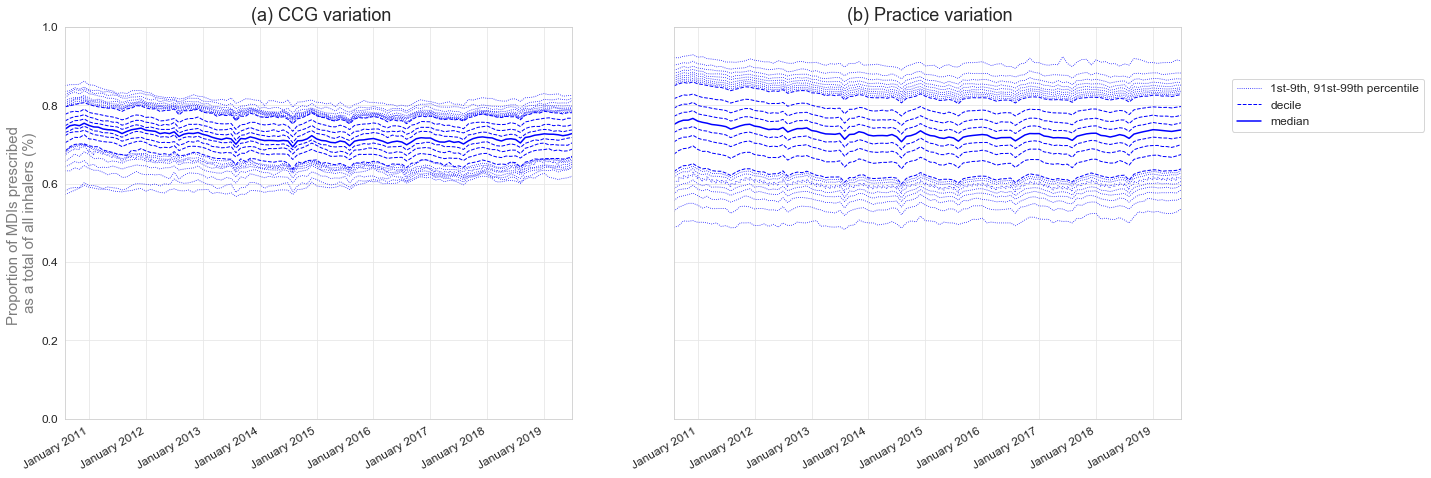

In [17]:
f = plt.figure(figsize=(20,8))
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    df_ccg_salb,
    period_column='month',
    column='measure_value',
    title=" (a) CCG variation",
    ylabel="Proportion of MDIs prescribed \n as a total of all inhalers (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot, 
) 

charts.deciles_chart(
    df_practice_salb,
    period_column='month',
    column='measure_value',
    title=" (b) Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot,
) 

plt.ylim(0, 1)
plt.show()

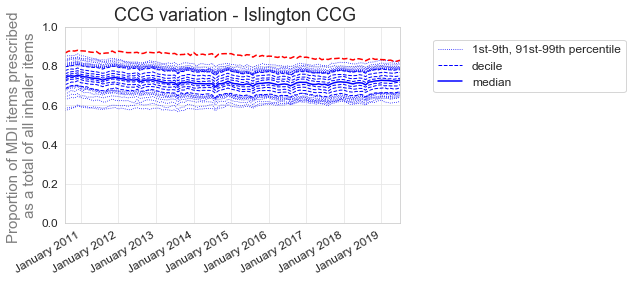

In [18]:
###here we chart a ccg example
charts.deciles_chart(
    df_ccg_salb,
    period_column='month',
    column='measure_value',
    title=" CCG variation - Islington CCG",
    ylabel="Proportion of MDI items prescribed \n as a total of all inhaler items ",
    show_outer_percentiles=True,
    show_legend=True 
) 


#add in example CCG (Islington - 08h)
df_subject = df_ccg_salb.loc[df_ccg_salb['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')
plt.ylim(0, 1)
plt.show()

In [19]:
ccg_june_salb = df_ccg_salb.loc[df_ccg_salb['month'] == "2019-06-01"].groupby('pct').sum().reset_index()
ccg_june_salb.head()

,pct,numerator,denominator,measure_value
0,00C,5443,8364,0.650765
1,00D,21809,32734,0.666249
2,00J,15032,22591,0.665398
3,00K,19913,29711,0.670223
4,00L,17361,28312,0.613203


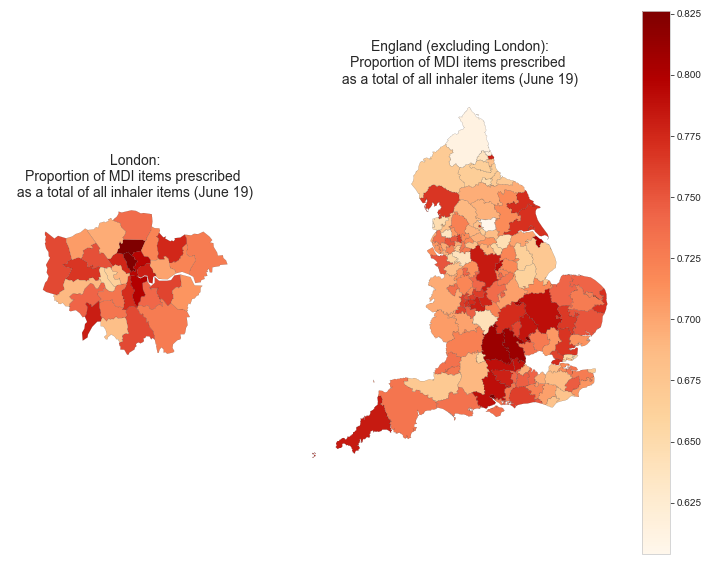

In [20]:
plt.figure(figsize=(12,10))
plt = maps.ccg_map(ccg_june_salb, title="Proportion of MDI items prescribed \n as a total of all inhaler items (June 19) ",  column='measure_value' , cartogram=False, separate_london=True)
plt.show()